# Workbook to genotype bam files
8/18/16
Amanda Everitt

In [128]:
%%bash
#MAKE input SNP file to use to genotype

awk '$1=="2L"{print}' MS_realigned_SNPs.out | awk '$2 <= 5000000 {print}' > 2L_snp
#Using 2L from 0-5Kb - sample every other row
awk '$1=="X"{print}' MS_realigned_SNPs.out | awk '$2 >= 10000000 && $2<=20000000 {print}' > X_snp
#Using X from 10- 20Kb - sample every 4th row
cat 2L_snp X_snp > infile_SNP
rm 2L_snp
rm X_snp
wc -l infile_SNP

11540 infile_SNP


In [129]:
##Make VCF files with genotype call for both of the reduced set from above
import os, subprocess

#make .sh files
cwd = "/home/everitt/CNV/Genotyping"
infile_ref = "/mnt/popi/archive/reference/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP4.fa"
infile_SNP = "/home/everitt/Tools/infile_SNP"
samples_dir = "/mnt/popi/home/travc/seq_v2/AgamP4/samples"
for infile in os.listdir(samples_dir):
    if infile.startswith("06SEL"):
        sh_file = open("{}/{}.sh".format(cwd,infile),"w")
        sh_file.write('samtools mpileup -uf {} -l {} {}/{}/{}.bam | bcftools call -c - > {}/output/{}.vcf \n'.format(infile_ref, infile_SNP, samples_dir, infile, infile, cwd, infile))

In [130]:
%%bash
#run all .sh files in parallel
cd /home/everitt/CNV/Genotyping/
cat *.sh > all.sh
head -2 all.sh 
#screen
#parallel --gnu --ungroup --nice 9 -a all.sh

#May need to enter:
#samtools mpileup -uf /mnt/popi/archive/reference/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP4.fa -l /home/everitt/Tools/infile_SNP /home/bradmain/gambiae/gene_flow/lcn/210/markdup.bam | bcftools call -c - > /home/everitt/CNV/Genotyping/output/210.vcf
#samtools mpileup -uf /mnt/popi/archive/reference/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP4.fa -l /home/everitt/Tools/infile_SNP /home/bradmain/gambiae/gene_flow/lcn/233/markdup.bam | bcftools call -c - > /home/everitt/CNV/Genotyping/output/233.vcf
#samtools mpileup -uf /mnt/popi/archive/reference/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP4.fa -l /home/everitt/Tools/infile_SNP /home/bradmain/gambiae/gene_flow/lcn/234/markdup.bam | bcftools call -c - > /home/everitt/CNV/Genotyping/output/234.vcf
#samtools mpileup -uf /mnt/popi/archive/reference/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP4.fa -l /home/everitt/Tools/infile_SNP /mnt/popi/home/travc/seq/hiseq1_map_AgamP4/02SEL80/realigned_fixed.bam | bcftools call -c - > /home/everitt/CNV/Genotyping/output/02SEL80.vcf
#samtools mpileup -uf /mnt/popi/archive/reference/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP4.fa -l /home/everitt/Tools/infile_SNP /mnt/popi/home/travc/seq/hiseq1_map_AgamP4/O10SEL124/realigned_fixed.bam | bcftools call -c - > /home/everitt/CNV/Genotyping/output/010SEL124.vcf
#samtools mpileup -uf /mnt/popi/archive/reference/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP4.fa -l /home/everitt/Tools/infile_SNP /mnt/popi/home/travc/seq/hiseq1_map_AgamP4/O10SEL99/realigned_fixed.bam | bcftools call -c - > /home/everitt/CNV/Genotyping/output/010SEL99.vcf

samtools mpileup -uf /mnt/popi/archive/reference/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP4.fa -l /home/everitt/Tools/infile_SNP /mnt/popi/home/travc/seq_v2/AgamP4/samples/06SELI0015/06SELI0015.bam | bcftools call -c - > /home/everitt/CNV/Genotyping/output/06SELI0015.vcf 
samtools mpileup -uf /mnt/popi/archive/reference/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP4.fa -l /home/everitt/Tools/infile_SNP /mnt/popi/home/travc/seq_v2/AgamP4/samples/06SELI0023/06SELI0023.bam | bcftools call -c - > /home/everitt/CNV/Genotyping/output/06SELI0023.vcf 


cat: all.sh: input file is output file


In [168]:
#Script Brad wrote to find proportion M & S and output it graphically
import sys, math, numpy, os
import pylab as P


#Input SNP file here to polarize to proportion S.
cns={}
for line in open("MS_realigned_SNPs.out"):
    i=line.strip().split()
    if line[0]=="#":
        continue
    C=i[0]
    p=int(i[1])
    m=i[3]
    s=i[5]
    if C not in cns:
        cns[C]={}
    cns[C][p]=[m,s]

def vcfdict(vcf):
    D={}
    for line in open(vcf):
        if line[0]=="#":
            continue
        i=line.strip().split()
        CHR=i[0]
        POS=int(i[1])
        if CHR not in D:
            D[CHR]={}
        if i[-2]=="PL":
            genotype=[i[3],i[3]] 
            if genotype[0]==cns[CHR][POS][0]:
                call=["M","M"] #I added 2 alleles here representing the homozygote.
            elif genotype[0]==cns[CHR][POS][1]:
                call=["S","S"]
            else:
                call=[]
        else:
            status=i[-1][0]
            if status=='0':
                genotype=[i[3],i[4]]
                c=0
                for allele in genotype:
                    if allele in cns[CHR][POS]:
                        c+=1
                if c==2:
                    call=["M","S"] #This is the major change to the previous version. I am accounting for HET's much better.
                else:
                    call=[]
            elif status=='1':
                genotype=i[4]
                if genotype==".":
                    genotype=i[3]
                if genotype==cns[CHR][POS][0]:
                    call=["M","M"] #I added 2 alleles here representing the homozygote.
                elif genotype==cns[CHR][POS][1]:
                    call=["S","S"]
                elif len(genotype.split(','))>=2:
                    alleles=genotype.split(",")
                    c=0
                    for allele in alleles:
                        if allele in cns[CHR][POS]:
                            c+=1
                    if c==2:
                        call=["M","S"] #This is the major change to the previous version. I am accounting for HET's much better.
                    else:
                        call=[]
                else:
                    call=[]
            else:
                call=[]
        D[CHR][POS]=call
    return D

def MS(dictionary, cwd, ID):
    count=0
    outfile = open("{}/{}_proportions".format(cwd,ID), "w")
    for chromosome in dictionary:
        count+=1
        length=max(dictionary[chromosome])
        bins=int(math.floor(length/100000))
        x=[]
        y=[]
        snpdensity=[]
        bins=bins*4  #sliding window
        for kb in range(bins):
            MScount=["M","S"]
            windowL=25000*kb
            windowR=windowL+100000
            HETcount=0
            for pos in dictionary[chromosome]:
                if pos>=windowL and pos<=windowR:
                    if len(dictionary[chromosome][pos])<2:
                        continue
                    MScount.append(dictionary[chromosome][pos][0])
                    MScount.append(dictionary[chromosome][pos][1])
                    if dictionary[chromosome][pos][0]!=dictionary[chromosome][pos][1]:
                        HETcount+=1
            TOTAL=float(MScount.count("S"))+float(MScount.count("M"))

            outfile.write(str(chromosome) + '\t' + str((windowL+50000)) + '\t' + str((float(MScount.count("S"))/TOTAL)) + '\t' + str(TOTAL) + '\t' + str(HETcount) + '\n')
            x.append(windowL+50000)
            y.append(float(MScount.count("S"))/(float(MScount.count("S"))+float(MScount.count("M"))))
            snpdensity.append(len(MScount)-2)
    #print ("END")

#SEL=vcfdict("/home/everitt/CNV/Genotyping/output/06SELI0015.vcf")
#MS(SEL)
cwd= "/home/everitt/CNV/Genotyping/output/"
for infile in os.listdir(cwd):
    if infile.endswith(".vcf"):
        input = cwd+infile
        ID= infile[:-4]
        SEL = vcfdict(input)
        MS(SEL, cwd, ID)
print ("END")

END


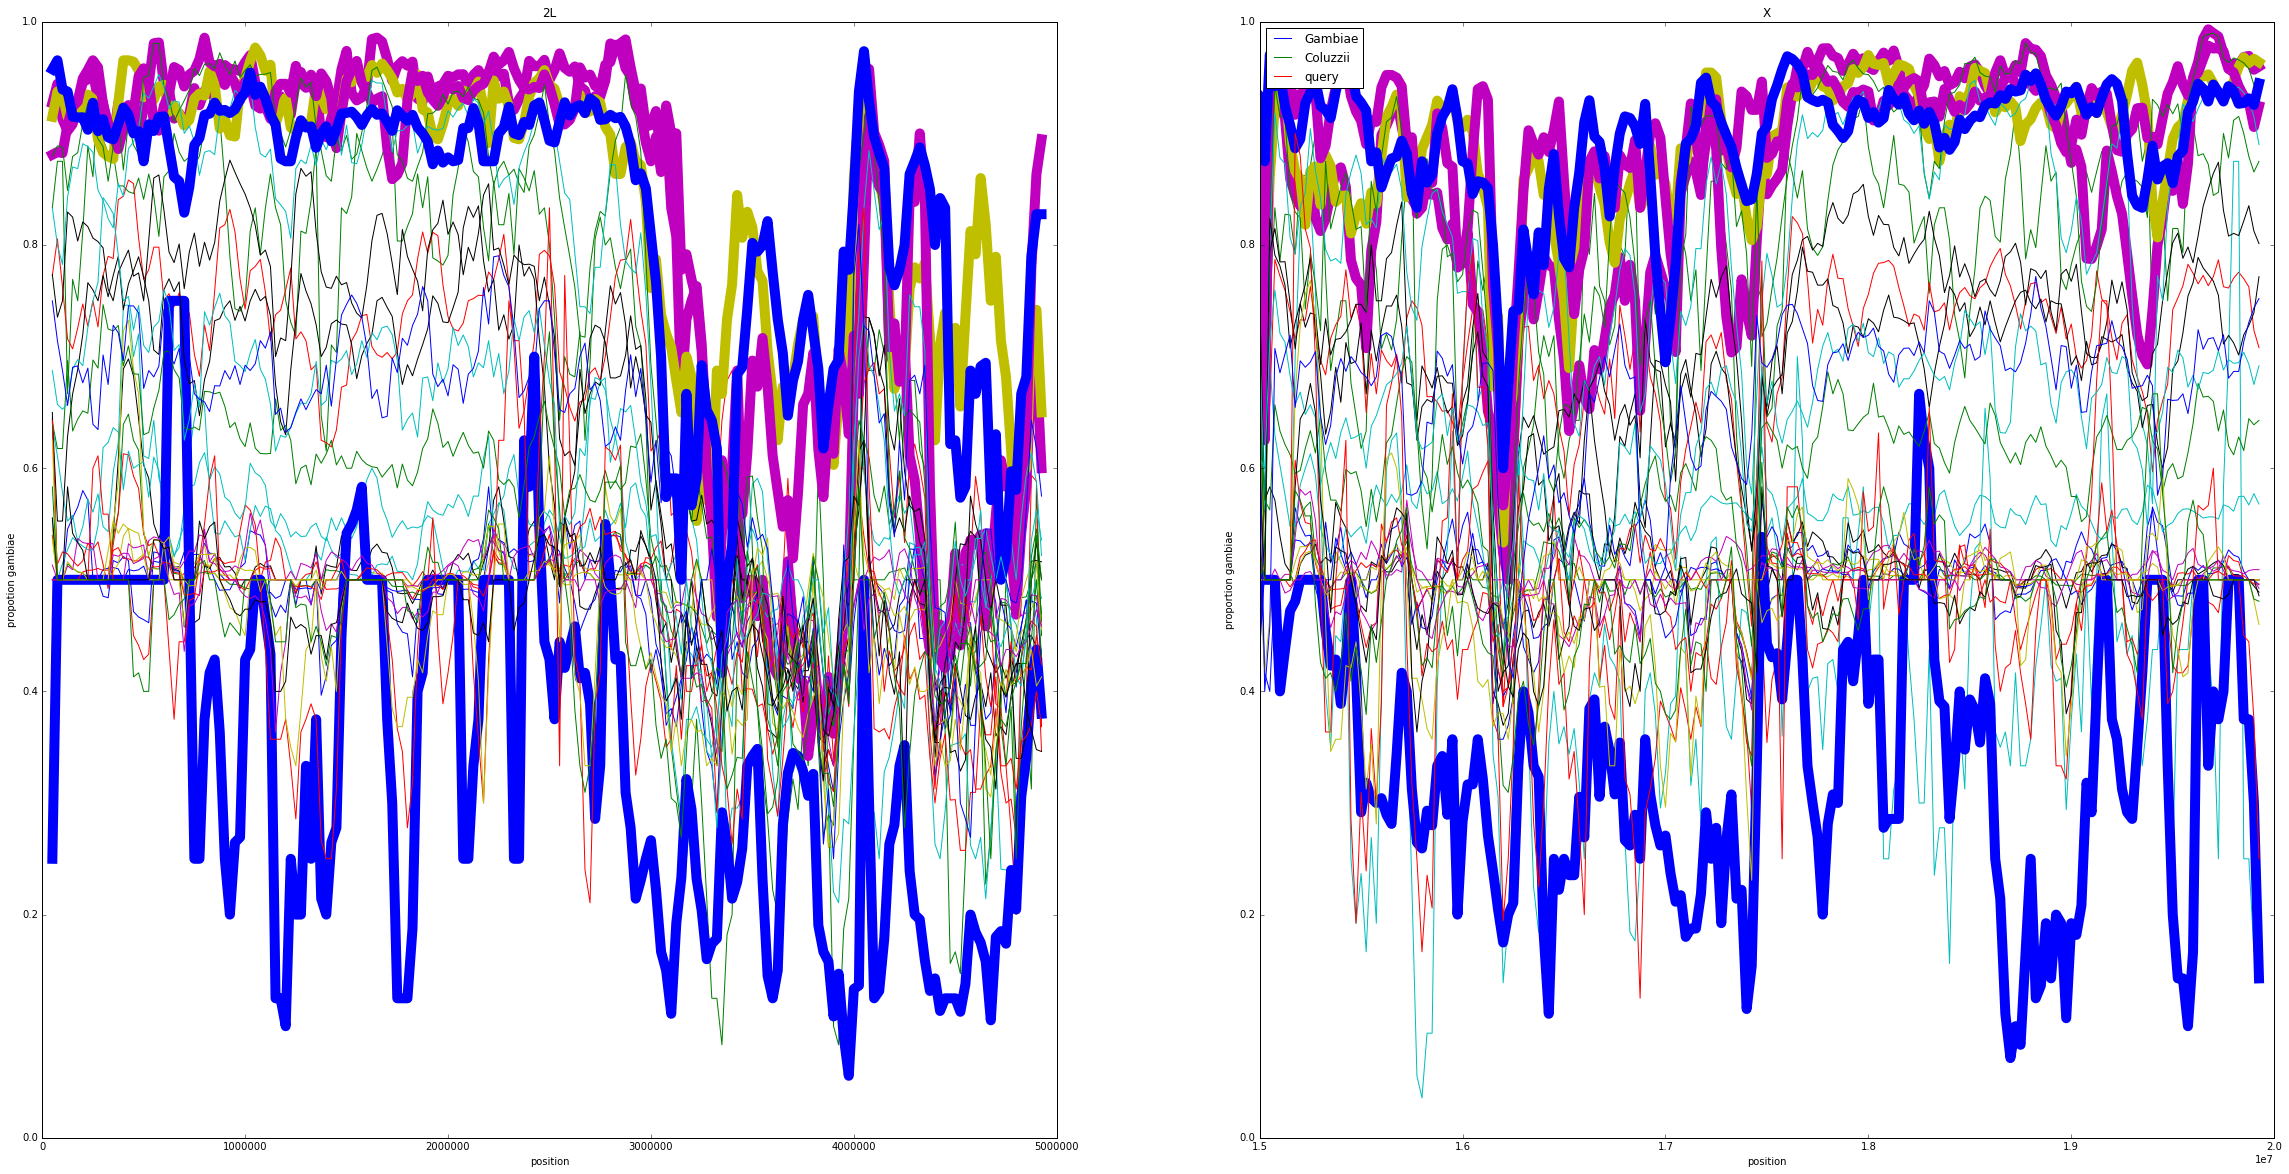

In [171]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (40.0, 20.0)

def plot(input):
    infile = open(input)
    #print (input)
    L = 1
    special = []
    x_2L = []
    y_2L = []
    x_X = []
    y_X = []
    for line in infile:
        if line.split('\t')[0] == "2L":
            proportion = line.split('\t')[2]
            y_2L.append(proportion)
            position = line.split('\t')[1]
            x_2L.append(position)
        elif line.split('\t')[0] == "X":
            proportion = line.split('\t')[2]
            y_X.append(proportion)
            position = line.split('\t')[1]
            x_X.append(position)
    if "010SEL99_proportions" in input or "02SEL80_proportions" in input or "233_proportions" in input or "234_proportions" in input or "210_proportions" in input :
        L = 10
    plt.subplot(1,2,1)
    plt.plot(x_2L, y_2L,linewidth= L)
    plt.title('2L')
    plt.xlabel('position')
    plt.ylabel('propotion gambiae')
    
    plt.subplot(1,2,2)
    plt.plot(x_X, y_X, linewidth= L)
    plt.title('X')
    plt.xlabel('position')
    plt.ylabel('proportion gambiae')
    plt.xlim(15000000)
    
#plt.plot(x, y)

fig, ax = plt.subplots(nrows=1,ncols=2)
cwd = "/home/everitt/CNV/Genotyping/output"
L=1
for input in os.listdir(cwd):
    if input.endswith("proportions"):
        plot("{}/{}".format(cwd,input))
#input1 = "/home/everitt/CNV/Genotyping/output/010SEL99_proportions"
#input2 = "/home/everitt/CNV/Genotyping/output/062SEL80_proportions"
#input3 = "/home/everitt/CNV/Genotyping/output/06SELI0035_proportions"
#plot(input1)
#plot(input2)
#plot(input3)

plt.legend(['Gambiae', 'Coluzzii','query'], loc='upper left')

plt.show()